In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Function to calculate p values using statsmodels regression, result similar to df.corr()
def calculate_pvalues(df):

    # Start as True, but will be only on the first loop
    first = True
    
    for c in df.columns:

        # If column values are binary use logit else use linreg
        if df[c].unique().shape == (2,):

            log = sm.Logit(df[c], df.loc[:, df.columns != c], verbose=0).fit(disp=0)

            # If first column df_output = p_values dataframe, else concatenate with df_output
            if first:            
                df_output = pd.DataFrame(index=log.pvalues.index, data=log.pvalues, columns=[c])
            else:
                df_output = pd.concat([df_output, pd.DataFrame(index=log.pvalues.index, data=log.pvalues, columns=[c])], axis=1)
                
        else:

            lin = sm.OLS(df[c], df.loc[:, df.columns != c], verbose=0).fit(disp=0)

            # If first column df_output = p_values dataframe, else concatenate with df_output
            if first:            
                df_output = pd.DataFrame(index=lin.pvalues.index, data=lin.pvalues, columns=[c])
            else:
                df_output = pd.concat([df_output, pd.DataFrame(index=lin.pvalues.index, data=lin.pvalues, columns=[c])], axis=1)

        # Only on first loop
        first = False

    return df_output.round(4).fillna(0)

In [3]:
df = pd.read_csv('test_data_CANDIDATE.csv', index_col=0)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,nar,hc,sk,trf
index,,,,,,,,,,,,,,,,,
0,49,M,10000,130,269.0,0,1,163,0,0.0,2.0,0,2,2,0,1,6797.761892
1,61,F,10000,138,166.0,0,0,125,1,3.6,NaN,1,2,2,1,3,4307.686943
2,46,F,10000,140,311.0,0,1,120,1,1.8,NaN,2,3,2,0,1,4118.077502
3,69,F,10000,140,254.0,0,0,146,0,2.0,1.0,3,3,2,1,0,7170.849469
4,51,F,10000,100,222.0,0,1,143,1,1.2,1.0,0,2,2,1,0,5579.040145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,54,F,10000,125,273.0,0,0,152,0,0.5,0.0,1,2,2,2,0,6293.123474
284,42,F,10000,120,240.0,1,1,194,0,0.8,0.0,0,3,2,0,1,3303.841931
285,67,M,10000,106,223.0,0,1,142,0,0.3,NaN,2,2,2,1,0,3383.029119


In [5]:
# Changes the order of the columns, I wanted sex to be the first
df = df[['sex', 'age', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca',
         'thal', 'nar', 'hc', 'sk', 'trf']]
df

,sex,age,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,nar,hc,sk,trf
index,,,,,,,,,,,,,,,,,
0,M,49,10000,130,269.0,0,1,163,0,0.0,2.0,0,2,2,0,1,6797.761892
1,F,61,10000,138,166.0,0,0,125,1,3.6,NaN,1,2,2,1,3,4307.686943
2,F,46,10000,140,311.0,0,1,120,1,1.8,NaN,2,3,2,0,1,4118.077502
3,F,69,10000,140,254.0,0,0,146,0,2.0,1.0,3,3,2,1,0,7170.849469
4,F,51,10000,100,222.0,0,1,143,1,1.2,1.0,0,2,2,1,0,5579.040145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,F,54,10000,125,273.0,0,0,152,0,0.5,0.0,1,2,2,2,0,6293.123474
284,F,42,10000,120,240.0,1,1,194,0,0.8,0.0,0,3,2,0,1,3303.841931
285,M,67,10000,106,223.0,0,1,142,0,0.3,NaN,2,2,2,1,0,3383.029119


In [6]:
# Changing the names of the columns to something more understandable
mapping = {'trestbps':'blood_pressure', 'chol': 'cholesterol', 'fbs': 'blood_sugar', 
                'restecg': 'ekg_results', 'thalach': 'max_heart_rate', 'nar': 'n_arms', 
                'sk':'skin_colour', 'hc':'hair_colour', 'trf':'time_in_traffic', 'oldpeak':'stress_test', 'slope':'stress_test_slope'}

df = df.rename(columns=mapping)
df

,sex,age,cp,blood_pressure,cholesterol,blood_sugar,ekg_results,max_heart_rate,exang,stress_test,stress_test_slope,ca,thal,n_arms,hair_colour,skin_colour,time_in_traffic
index,,,,,,,,,,,,,,,,,
0,M,49,10000,130,269.0,0,1,163,0,0.0,2.0,0,2,2,0,1,6797.761892
1,F,61,10000,138,166.0,0,0,125,1,3.6,NaN,1,2,2,1,3,4307.686943
2,F,46,10000,140,311.0,0,1,120,1,1.8,NaN,2,3,2,0,1,4118.077502
3,F,69,10000,140,254.0,0,0,146,0,2.0,1.0,3,3,2,1,0,7170.849469
4,F,51,10000,100,222.0,0,1,143,1,1.2,1.0,0,2,2,1,0,5579.040145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,F,54,10000,125,273.0,0,0,152,0,0.5,0.0,1,2,2,2,0,6293.123474
284,F,42,10000,120,240.0,1,1,194,0,0.8,0.0,0,3,2,0,1,3303.841931
285,M,67,10000,106,223.0,0,1,142,0,0.3,NaN,2,2,2,1,0,3383.029119


In [7]:
# First of all lets analise the quantity of nulls
df.isna().sum()

sex                    0
age                    0
cp                     0
blood_pressure         0
cholesterol           16
blood_sugar            0
ekg_results            0
max_heart_rate         0
exang                  0
stress_test            0
stress_test_slope    143
ca                     0
thal                   0
n_arms                 0
hair_colour            0
skin_colour            0
time_in_traffic        0
dtype: int64

In [8]:
# Nothing too critical for cholesterol column, but for slope it may be significant, but we still are not sure if we will use
# slope column. Let's replace them with zeroes
df = df.fillna(0)
df

,sex,age,cp,blood_pressure,cholesterol,blood_sugar,ekg_results,max_heart_rate,exang,stress_test,stress_test_slope,ca,thal,n_arms,hair_colour,skin_colour,time_in_traffic
index,,,,,,,,,,,,,,,,,
0,M,49,10000,130,269.0,0,1,163,0,0.0,2.0,0,2,2,0,1,6797.761892
1,F,61,10000,138,166.0,0,0,125,1,3.6,0.0,1,2,2,1,3,4307.686943
2,F,46,10000,140,311.0,0,1,120,1,1.8,0.0,2,3,2,0,1,4118.077502
3,F,69,10000,140,254.0,0,0,146,0,2.0,1.0,3,3,2,1,0,7170.849469
4,F,51,10000,100,222.0,0,1,143,1,1.2,1.0,0,2,2,1,0,5579.040145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,F,54,10000,125,273.0,0,0,152,0,0.5,0.0,1,2,2,2,0,6293.123474
284,F,42,10000,120,240.0,1,1,194,0,0.8,0.0,0,3,2,0,1,3303.841931
285,M,67,10000,106,223.0,0,1,142,0,0.3,0.0,2,2,2,1,0,3383.029119


In [9]:
# Let's check if the most important columns is ok
df['sex'].unique()

array(['M', 'F', 'm', 'f'], dtype=object)

In [10]:
# Let's convert all to caps
df['sex'] = df['sex'].str.upper() 
df['sex'].unique()

array(['M', 'F'], dtype=object)

In [11]:
# Let's check if the dataset it balanced
r = df.groupby('sex').count()[df.columns[1]]
r

sex
F    196
M     92
Name: age, dtype: int64

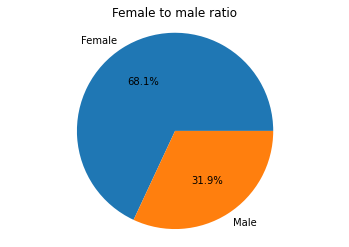

In [12]:
# Piechart
data = [r[0] / sum(r), r[1] / sum(r)]
plt.pie(data, labels=['Female','Male'], autopct='%1.1f%%')
plt.title('Female to male ratio')
plt.axis('equal')
plt.show()

In [13]:
# Let's check if everything is ok
df.nunique()

sex                    2
age                   41
cp                     1
blood_pressure        48
cholesterol          150
blood_sugar            2
ekg_results            3
max_heart_rate        90
exang                  2
stress_test           40
stress_test_slope      3
ca                     5
thal                   4
n_arms                 3
hair_colour            3
skin_colour            4
time_in_traffic      288
dtype: int64

In [14]:
# There's something unusual, it looks like cp columns values are all the same, let's eliminate it
del df['cp']
df

,sex,age,blood_pressure,cholesterol,blood_sugar,ekg_results,max_heart_rate,exang,stress_test,stress_test_slope,ca,thal,n_arms,hair_colour,skin_colour,time_in_traffic
index,,,,,,,,,,,,,,,,
0,M,49,130,269.0,0,1,163,0,0.0,2.0,0,2,2,0,1,6797.761892
1,F,61,138,166.0,0,0,125,1,3.6,0.0,1,2,2,1,3,4307.686943
2,F,46,140,311.0,0,1,120,1,1.8,0.0,2,3,2,0,1,4118.077502
3,F,69,140,254.0,0,0,146,0,2.0,1.0,3,3,2,1,0,7170.849469
4,F,51,100,222.0,0,1,143,1,1.2,1.0,0,2,2,1,0,5579.040145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,F,54,125,273.0,0,0,152,0,0.5,0.0,1,2,2,2,0,6293.123474
284,F,42,120,240.0,1,1,194,0,0.8,0.0,0,3,2,0,1,3303.841931
285,M,67,106,223.0,0,1,142,0,0.3,0.0,2,2,2,1,0,3383.029119


In [15]:
# Let's take a look at the value on the dataset
df.describe()

,age,blood_pressure,cholesterol,blood_sugar,ekg_results,max_heart_rate,exang,stress_test,stress_test_slope,ca,thal,n_arms,hair_colour,skin_colour,time_in_traffic
count,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000
mean,54.479167,131.315972,231.520833,0.145833,0.531250,149.611111,0.326389,1.049653,0.701389,0.725694,2.302083,1.972222,0.586806,0.940972,4176.658930
std,9.137333,17.476938,76.255847,0.353553,0.527035,22.782600,0.469708,1.164935,0.818598,1.024661,0.615476,0.219103,0.651532,1.001735,1988.789872
min,29.000000,94.000000,0.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,653.415425
25%,47.000000,120.000000,204.000000,0.000000,0.000000,133.750000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,2671.229092
50%,56.000000,130.000000,235.500000,0.000000,1.000000,152.500000,0.000000,0.800000,0.000000,0.000000,2.000000,2.000000,0.000000,1.000000,4222.567419
75%,61.000000,140.000000,270.250000,0.000000,1.000000,166.250000,1.000000,1.600000,1.000000,1.000000,3.000000,2.000000,1.000000,2.000000,5885.708843
max,77.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,2.000000,2.000000,3.000000,7389.481550


<AxesSubplot:xlabel='age', ylabel='Count'>

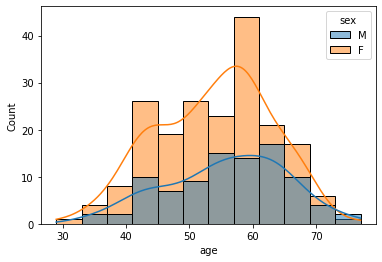

In [16]:
# Nothing unusual here
sns.histplot(x='age', hue='sex', kde=True, data=df)

<AxesSubplot:xlabel='blood_pressure', ylabel='Count'>

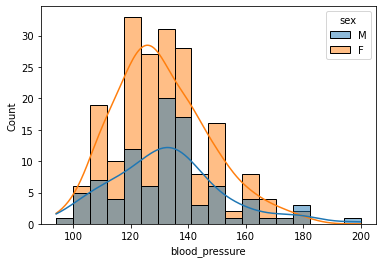

In [17]:
# Both the mean of men and women blood pressure on the data are above the pressure classified as normal (120)
# https://www.ncbi.nlm.nih.gov/books/NBK9633/table/A32/
sns.histplot(x='blood_pressure', hue='sex', kde=True, data=df)

<AxesSubplot:xlabel='cholesterol', ylabel='Count'>

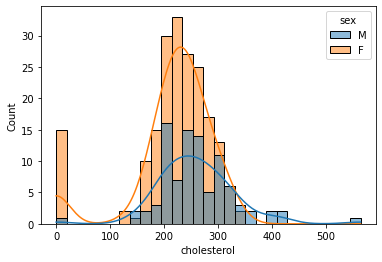

In [18]:
# Some outliers here, the values that are 0 are the values I used 
# fillna in the begining of the notebook
sns.histplot(x='cholesterol', hue='sex', kde=True, data=df)

<AxesSubplot:xlabel='cholesterol', ylabel='Count'>

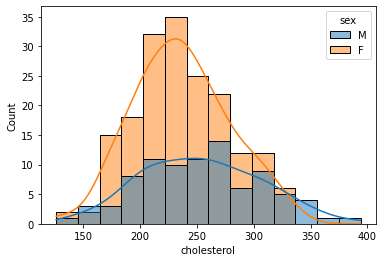

In [19]:
# Both men and women cholesterol mean is above classified as healthy (200)
# https://medlineplus.gov/cholesterollevelswhatyouneedtoknow.html
df = df[df['cholesterol'] > 50]
df = df[df['cholesterol'] < 400]
sns.histplot(x='cholesterol', hue='sex', kde=True, data=df)

<AxesSubplot:xlabel='max_heart_rate', ylabel='Count'>

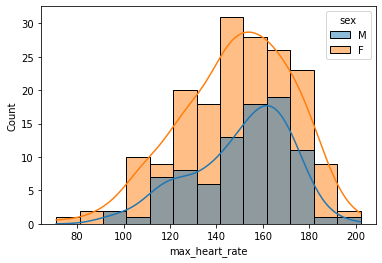

In [20]:
# Nothing unusual here
sns.histplot(x='max_heart_rate', hue='sex', kde=True, data=df)

<AxesSubplot:xlabel='time_in_traffic', ylabel='Count'>

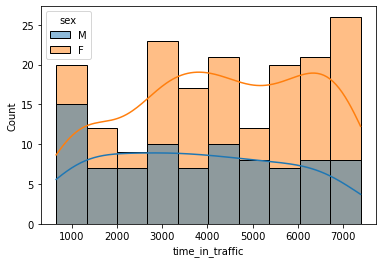

In [21]:
# That's unexpected, I wish I had a column with with what means of transport each patient has
sns.histplot(x='time_in_traffic', hue='sex', kde=True, data=df)

In [22]:
# Let's convert to binary encoding
df.replace('M', 1, inplace=True)
df.replace('F', 0, inplace=True)
df['sex']

index
0      1
1      0
2      0
3      0
4      0
      ..
283    0
284    0
285    1
286    0
287    0
Name: sex, Length: 268, dtype: int64

In [23]:
# Correlation matrix
corr = df.corr()
corr

,sex,age,blood_pressure,cholesterol,blood_sugar,ekg_results,max_heart_rate,exang,stress_test,stress_test_slope,ca,thal,n_arms,hair_colour,skin_colour,time_in_traffic
sex,1.000000,0.055448,0.034408,0.176294,-0.039413,0.059367,0.037911,-0.145377,-0.142252,-0.007158,-0.160081,-0.233752,-0.099393,0.221290,-0.032219,-0.119039
age,0.055448,1.000000,0.263874,0.198916,0.116617,-0.099764,-0.424462,0.091426,0.169850,-0.038302,0.283957,0.060900,0.061975,0.025626,0.163809,0.112251
blood_pressure,0.034408,0.263874,1.000000,0.123556,0.196303,-0.093164,-0.083102,0.055191,0.199190,-0.010541,0.083901,0.044138,-0.008669,-0.013427,0.096565,0.008780
cholesterol,0.176294,0.198916,0.123556,1.000000,0.015046,-0.094243,-0.025519,0.071553,-0.002608,-0.000511,0.058803,0.065943,-0.018561,-0.064760,0.008379,-0.041989
blood_sugar,-0.039413,0.116617,0.196303,0.015046,1.000000,-0.051403,-0.005128,-0.019127,0.039725,-0.049944,0.121201,-0.041793,-0.002987,-0.102605,0.056504,-0.077708
ekg_results,0.059367,-0.099764,-0.093164,-0.094243,-0.051403,1.000000,0.040295,-0.054414,-0.034112,0.021269,-0.055095,0.003916,-0.006881,0.044186,0.027138,-0.034337
max_heart_rate,0.037911,-0.424462,-0.083102,-0.025519,-0.005128,0.040295,1.000000,-0.343237,-0.326632,0.247030,-0.207496,-0.073521,0.061203,-0.034094,0.053159,-0.063364
exang,-0.145377,0.091426,0.055191,0.071553,-0.019127,-0.054414,-0.343237,1.000000,0.294606,-0.072387,0.078165,0.203539,0.047178,-0.092401,0.031154,0.101719
stress_test,-0.142252,0.169850,0.199190,-0.002608,0.039725,-0.034112,-0.326632,0.294606,1.000000,-0.218481,0.195298,0.200068,0.016868,0.021825,0.030746,0.136273
stress_test_slope,-0.007158,-0.038302,-0.010541,-0.000511,-0.049944,0.021269,0.247030,-0.072387,-0.218481,1.000000,-0.030889,-0.118510,0.058800,-0.054979,-0.058246,-0.029260


In [24]:
# P values matrix
p_values = calculate_pvalues(df)
p_values

,sex,age,blood_pressure,cholesterol,blood_sugar,ekg_results,max_heart_rate,exang,stress_test,stress_test_slope,ca,thal,n_arms,hair_colour,skin_colour,time_in_traffic
age,0.1480,0.0000,0.0000,0.0000,0.7603,0.8577,0.0000,0.1609,0.9371,0.3116,0.0001,0.0811,0.0000,0.4378,0.0099,0.0427
blood_pressure,0.5080,0.0000,0.0000,0.0291,0.0549,0.8312,0.0000,0.9558,0.0014,0.9272,0.7929,0.1866,0.0088,0.8611,0.9391,0.9195
cholesterol,0.0019,0.0000,0.0291,0.0000,0.3231,0.3638,0.0006,0.0967,0.6375,0.6637,0.5537,0.0343,0.1544,0.1074,0.4020,0.3853
blood_sugar,0.6500,0.4531,0.0164,0.5062,0.0000,0.5737,0.8574,0.8996,0.9586,0.3039,0.1572,0.2134,0.6540,0.0934,0.5055,0.0866
ekg_results,0.3029,0.8577,0.8312,0.3638,0.3502,0.0000,0.2593,0.5889,0.8456,0.8079,0.9046,0.2816,0.1788,0.7700,0.5734,0.7651
max_heart_rate,0.9056,0.0000,0.0000,0.0006,0.4384,0.2593,0.0000,0.0000,0.0021,0.0009,0.4609,0.0010,0.0000,0.7821,0.0750,0.3538
exang,0.2866,0.3686,0.3910,0.0764,0.4924,0.7488,0.0000,0.0000,0.0042,0.4323,0.6908,0.0062,0.0172,0.1548,0.4997,0.4763
stress_test,0.1914,0.9371,0.0014,0.6375,0.8489,0.8456,0.0021,0.0056,0.0000,0.0136,0.0682,0.0999,0.5258,0.3593,0.8754,0.1430
stress_test_slope,0.4190,0.3116,0.9272,0.6637,0.3053,0.8079,0.0009,0.2549,0.0136,0.0000,0.6339,0.0647,0.8591,0.5432,0.2493,0.7624
ca,0.0174,0.0001,0.7929,0.5537,0.1932,0.9046,0.4609,0.4275,0.0682,0.6339,0.0000,0.2941,0.0701,0.6394,0.5995,0.9732


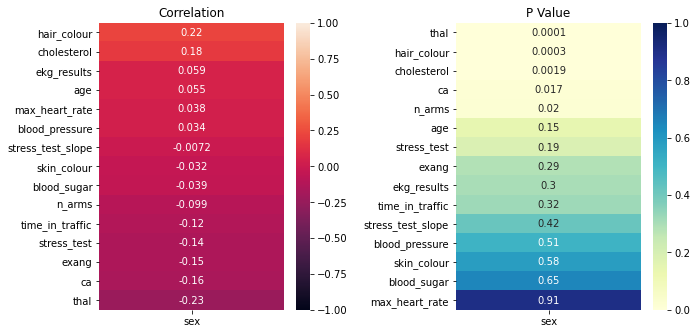

In [25]:
# plots a one column heatmap of correlation and p value for sex column

# Creates subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Column of interest
col = 'sex'

# Plots correlation matrix for current column x all others
corr = pd.DataFrame(corr.sort_values(by=col, ascending=False)[col]).drop(col)
sns.heatmap(corr, annot=True, ax=axes[0], vmin=-1, vmax=1)        
axes[0].set_title('Correlation')

# Plots p value matrix for current column x all others
p_values = pd.DataFrame(p_values.sort_values(by=col, ascending=True)[col]).drop(col)
sns.heatmap(p_values, annot=True, ax=axes[1], cmap="YlGnBu", vmin=0, vmax=1)
axes[1].set_title('P Value')
fig.tight_layout(pad=2.0)

In [26]:
# Let's keep the pvalues smaller than 5%
cols = list(p_values.index)
cols = [a for a,b in zip(cols, p_values['sex'].values) if b < 0.05]
cols = ['sex'] + cols
cols

['sex', 'thal', 'hair_colour', 'cholesterol', 'ca', 'n_arms']

In [27]:
# Let's filter the columns of interest
df_pvalue = df[cols]
df_pvalue

,sex,thal,hair_colour,cholesterol,ca,n_arms
index,,,,,,
0,1,2,0,269.0,0,2
1,0,2,1,166.0,1,2
2,0,3,0,311.0,2,2
3,0,3,1,254.0,3,2
4,0,2,1,222.0,0,2
...,...,...,...,...,...,...
283,0,2,2,273.0,1,2
284,0,3,0,240.0,0,2
285,1,2,1,223.0,2,2


In [28]:
# Calculates accuracy, precision, specificity and sensitivity 
def model_rating(clf, X_train, y_train, X_test, y_test, cutoff = 0.5):  

    print('--------------------------Train--------------------------')

    y_p = clf.predict_proba(X_train)[:,1]

    # Compair with cutoff threshold
    y_pred = y_p > cutoff

    # Gets the true negatives, false positives, false negatives and true positives
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()

    # Create dataframe to present data
    results = pd.DataFrame([[tn, fp], [fn, tp]], columns = ['Predicted Female', 'Predicted Male']) 
    results.index = ['Actual Female', 'Actual Male']
    print(results)

    print('---------------------------------------------------------')

    # Calculates results
    accuracy = (tn + tp) / (tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall_sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Create dataframe to present data
    results = pd.DataFrame([roc_auc_score(y_train, y_p), accuracy, precision, recall_sensitivity, specificity], 
                           columns = ['Values']) 

    results.index = ['ROC AUC Score', 'Accuracy', 'Precision', 'Recall/Sensitivity', 'Specificity']
    print(results)
    print('\n')

    if X_test is not None and y_test is not None:
        
        print('--------------------------Test--------------------------')

        y_p = clf.predict_proba(X_test)[:,1]

        # Compair with cutoff threshold
        y_pred = y_p > cutoff

        # Gets the true negatives, false positives, false negatives and true positives
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        # Create dataframe to present data
        results = pd.DataFrame([[tn, fp], [fn, tp]], columns = ['Predicted Female', 'Predicted Male']) 
        results.index = ['Actual Female', 'Actual Male']
        print(results)

        print('--------------------------------------------------------')

        # Calculates results
        accuracy = (tn + tp) / (tn + fp + fn + tp)
        precision = tp / (tp + fp)
        recall_sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        # Create dataframe to present data
        results = pd.DataFrame([roc_auc_score(y_test, y_p), accuracy, precision, recall_sensitivity, specificity], 
                               columns = ['Values']) 

        results.index = ['ROC AUC Score', 'Accuracy', 'Precision', 'Recall/Sensitivity', 'Specificity']
        print(results)

In [29]:
# Let's split them into train and test
train_pvalue = df_pvalue.loc[:, df_pvalue.columns != 'sex']
test_pvalue = df_pvalue['sex']

In [30]:
# Let's split them into train and test for the model
X_train, X_test, y_train, y_test = train_test_split(train_pvalue, test_pvalue, test_size=0.5, random_state=0)

In [32]:
# Let's check the size of the groups
print(len(X_train), len(y_train), len(X_test), len(y_test))

134 134 134 134


In [ ]:
# In order to optimize the parameters of the xg_boost, I've decided to do a grid search
parameters = {    
    'max_depth': range (4, 8, 1),
    'n_estimators': range(60, 250, 20),
    'learning_rate': [l/200 for l in list(range(10, 61, 5))]
}

estimator = xgb.XGBClassifier(
    objective= 'binary:logistic',
    seed=0,
    nthread=-1,
    reg_lambda=0
)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = -1,
    verbose=True,
)

grid_search.fit(X_train, y_train)

In [ ]:
# Uses the best values obtained on grid search for the model
clf = grid_search.best_estimator_
print(clf)

In [ ]:
# Let's see how it went
y_pred = clf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred)
print('Train accuracy:', train_accuracy)

y_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print('Test: accuracy', test_accuracy)

In [ ]:
# Doing some manual tinkering with base_score, colsample_bytree and reg_lambda
clf = xgb.XGBClassifier(base_score=0.59, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=7,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=60, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=0, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

clf.fit(X_train, y_train, verbose=False, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=20)

# Let's see how it changed
y_pred = clf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred)
print('Train accuracy:', train_accuracy)

y_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print('Test: accuracy', test_accuracy)

In [ ]:
# Let's see for train test
model_rating(clf, X_train, y_train, X_test, y_test, 0.5)

In [ ]:
# Let's see for the whole dataset
model_rating(clf, train_pvalue, test_pvalue, None, None, 0.5)

In [ ]:
# Let's save the model, the cutoff threshold used and the columns
clf.save_model('data/0.80_acc.model')

f = open('data/threshold.bin', 'w')
f.write(str(0.5))
f.close()

f = open('data/cols.bin', 'w')
f.write(str(','.join(cols)))
f.close()